## Final Assignment

In [59]:
# The Python modules you need for thisn assignment.
import pandas as pd
import os.path
import urllib.request 
import os.path
from matplotlib import pyplot as plt

url_dir = 'https://gawron.sdsu.edu/python_for_ss/course_core/data'

Loading and applying the style sheets in the next two cells customizes the styles of your notebook output,
in particular for how pandas `DataFrame`s are printed.

This is optional,  but it's interesting if you know anything about css files.

In [60]:
target_url1 = os.path.join(url_dir,'style-notebook.css')
target_url2 = os.path.join(url_dir,'style-table.css')

with urllib.request.urlopen(target_url1) as fh1:
    css1 = fh1.read().decode('utf8')
with urllib.request.urlopen(target_url2) as fh2:
    css2 = fh2.read().decode('utf8')
css = css1 + css2

In [61]:
from IPython.core.display import HTML
#css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

The next cell loads the `titles` DataFrame, the first of two used in this assignment.  There are only
two columns, `'title'`  and `'year'`.

In [4]:
titles = pd.read_csv(os.path.join(url_dir,'titles.csv'))
titles.head()

,title,year
0,The Patriarchs,2009
1,Angels in the Attic,1998
2,The Rapture,1991
3,Star na si Van Damme Stallone,2016
4,Sweet Talk,2004


The next cell loads the `cast` DataFrame, the second of two used in this assignment.  This is
large and will take a while.

In [70]:
# This is much larger and wont work in google colab at the moment
#cast = pd.read_csv(os.path.join(url_dir,'cast.csv'),index_col=0)
cast = pd.read_csv(os.path.join(url_dir,'truncated_cast.csv'),index_col=0)
cast.head()

,title,year,name,type,character,n
0,In the Land of the Head Hunters,1914,Paddy 'Malid,actor,Kenada,5.0
1,The Colour of Darkness,2016,Ketan Daraji -Gohel,actor,Chhagan,NaN
2,London Betty,2009,Isaiah Entsua -Mensah,actor,Camera Man,NaN
3,Candelabra,2014,Groovin .,actor,Lt. Dick Sims,5.0
4,Bad Ideas,2012,Hamid .,actor,The Diner,NaN


## Creating the actor graph

Steps

0.  Create a subDataFrame of `cast` (call it `cast0`) with only the rows whose value in the `n` column is less than 10 (we are going to restrict our attention to the most important roles in each film).

   ```
   Cast: 422,837      Cast0: 192,307
   Cast: 422,837      Cast0: 192,307
   ```

1.  Group the rows of `cast0` so that each group is a film, where a film is a pair of title and a year (remember that movies like *Ben Hur* have been made more than once).

   ```
   Number of groups = Number of films = 43,853
   ```
2.  Create a `networkx` graph (Call it `G`) using the `groupby` object from step 1, where each node is an actor/actress and there is an edge between two nodes if and only if the two actors were cast in the same film (according to `cast0`). 

   ```
   len(G) = 36,774 len(G.edges) = 511,762
   ```
   
   Hint: Start with an empty non directed `Graph` instance `G = nx.Graph()`.  You can build a graph
   entirely by adding edges. (the corresponding nodes will automatically be added).
   
   Hint:  You really only care about the `name` column in each group, so convert your `GroupBy` instance
   `gb` into a `SeriesGroupBy` instance by doing `gb["name"]`.  You can loop through a `SeriesGroupBy` instance 
     
     ```
     for xx in gb["name"]:
     ```
     
   and each `xx` will correspond to a group (a film). See exampe below. You should be able to use `xx` to find all the actors in that film and an add edges to `G` for each pair of actors in the film.  You will probably fiond the `G.add_edges_from(...)` method useful.

#### Step 0

In [63]:
len(cast)

422837

In [64]:
## Your code in the line below.  Let's just use top 9 roles.
cast0 =  cast[cast['n'] < 10]  ## Add a value  cast[cast['n'] < 10]
print(f"Cast: {len(cast):,}      Cast0: {len(cast0):,}")

Cast: 422,837      Cast0: 192,307


####  Step 1

In [71]:
# Create the Series groupby object using cast0.  Remember: A film is a pair of a title and a year.
# You can convert a groupby instance `gb` into a `SeriesGroupBy` instance by doing `gb["name"]`
# Then the group members of each group will be the cast of a film.
cg =   cast0.groupby(['title','year'])['name']    

In [72]:
len(cg)

43853

In [73]:
type(cg)

pandas.core.groupby.generic.SeriesGroupBy

#### Getting a group/Looping through the groups

We illustrate what the groupby object looks like/does. In the following cells `cg` is a `SeriesGroupBy` instance created by the code you wrote above, where each group in `cg` corresponds to a film (a title, year pair).

For example,

In [44]:
cg1_ser = cg.get_group(('Bringing Up Baby', 1938))

In [56]:
type(cg1_ser)

pandas.core.series.Series

The `Seriess` `cg1_ser` contains the 9 most important members of the cast of "Bringing Up Baby" (in no particular order).

In [45]:
cg1_ser

339187        Walter Catlett
650147            Fritz Feld
670773      Barry Fitzgerald
797118            Cary Grant
978604         George Irving
1810038      Charles Ruggles
2751791    Katharine Hepburn
3172772        Leona Roberts
3175356           May Robson
Name: name, dtype: object

So this film licenses 9 nodes and 36 edges in the graph, because
there are 9 actors, and since there are 36 actor pairs: (9*8)/2,
we draw 36 edges  among the 9 actors.

So this subpart of the actors graph looks like this (with the 9 actors
represented as the integers 1-9).

In [46]:
(9*8)/2

36.0

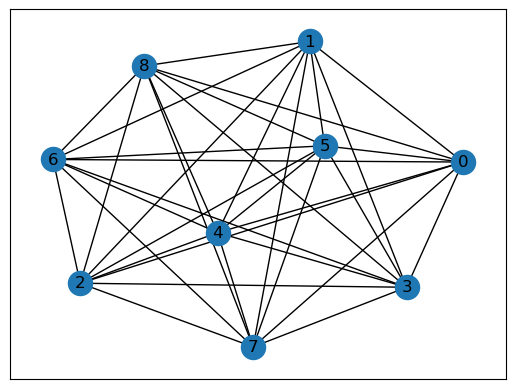

In [80]:
import networkx as nx

nx.draw_networkx(nx.complete_graph(9))

The number of egdes (36) comes from the formula for computing the number of pairs in a set of size n:  (n * (n-1))/2.

A more useful way of looking at it for writing the code is to pair each actor with all the actors below them in the cast list above.  Walter Catlett
gets paired with 8 other actors.  Fritz Feld gets paired with 7 others
(he's already paired with Walter Catlett). Barry Fitzgerald gets paired
with 6 others, and so on until Lenoa Roberts gets paired with May Robson. So the number of pairs is:

In [47]:
8 + 7 + 6 + 5 + 4 + 3 + 2 + 1

36

Looping through the `SeriesGroupBy` instance `cg`;  `cg` is an iterable of pairs of the form `((title,year), Ser)`, where `Ser` is a `pandas Series` containing the cast of the movie with title `title` made in year `year`. Since it's the cast you need to construct the graph, it's `Ser` you care about.

In [57]:
for g in  cg:
    print(len(g))
    print(g[0])
    print(type(g[1]))
    print(g[1])
    # Example stopped after looking at just one group (film) This film has only one cast member!
    break

2
('#REALITYHIGH', 2017)
<class 'pandas.core.series.Series'>
3211354    Alicia Sanz
Name: name, dtype: object


#### Step 2 Making the actor graph

In [49]:
import networkx as nx
G = nx.Graph()
# for g in cg:
for (film, g_ser) in cg:
    for (i,name) in enumerate(g_ser):
        G.add_edges_from([(name,name2) for name2 in g_ser.iloc[i+1:]])

###  Answer the following questions about G

Be sure to verify each answer with a code snippet.  You won't get credit
for your answers unless you provide the coe snippet that answers the question.

###  How many actors are there in G?

In [50]:
len(G)

36774

### How many edges does G have?

In [51]:
len(G.edges)

511762

### How many actors is Barry Fitzgerald connected to in `G`?  How many actors is Cary Grant connected to?

In [52]:
G.degree('Barry Fitzgerald'),G.degree('Cary Grant')

(62, 239)

###  What are the degree centrality values for Barry Fitzgerald and Cary Grant?

In [53]:
dc = nx.degree_centrality(G)

In [54]:
dc['Barry Fitzgerald'],dc['Cary Grant']

(0.0016860196339705763, 0.0064993337503059315)

### Have Christopher Walken and Cyndi Lauper ever appeared in a film together (according to `G`)?

Again if you are a film buff and you happen to know whether Cyndi Lauper and Barry Fitzgerald ever appeared in a movie together that is of no use
to you here.  You need the code snippet that looks up that fact in G.

In [55]:
('Cyndi Lauper','Barry Fitzgerald') in G.edges()

False

### Have Josephine Hutchinson and Cary Grant ever occured in a film together (according to `G`)?

In [17]:
('Josephine Hutchinson','Cary Grant' ) in G.edges()

True

### List the actors with the top 100 degree centralities

More specifically, construct a list with just the top 100 actors in the order
of their degree centrality in G from highest to lowest.  To be clear, the list should
**not** include the centrality values.

In [18]:
dc_il = sorted(dc.items(),key=lambda x:x[1],reverse=True)
dc_rankings = [act for (act, cc) in dc_il]
cc_rankings[:100]

['J. Farrell MacDonald',
 'Raymond Hatton',
 'Noah Beery',
 'Richard Tucker',
 'Tully Marshall',
 'Zasu Pitts',
 'Lucien Littlefield',
 'Alec B. Francis',
 'Jack Mulhall',
 'Joseph W. Girard',
 'Montagu Love',
 'George Fawcett',
 'Alan Hale',
 'Eugene Pallette',
 'Arthur Hoyt',
 'Jack Holt',
 'Hedda Hopper',
 'John Miljan',
 'Robert Frazer',
 'Lafe McKee',
 'Adolphe Menjou',
 'Wade Boteler',
 'Lewis Stone',
 'Hobart Bosworth',
 'Charles K. French',
 'Crauford Kent',
 'Henry B. Walthall',
 'Lois Wilson',
 'Philo McCullough',
 'Wheeler Oakman',
 'Fred Kohler',
 'Holmes Herbert',
 'Jean Hersholt',
 'Monte Blue',
 'Henry Kolker',
 'Buck Jones',
 'Harry Carey',
 "Guinn 'Big Boy' Williams",
 'Betty Compson',
 'William V. Mong',
 'Kenneth Harlan',
 'Walter McGrail',
 'Josef Swickard',
 'Wallace Beery',
 'Bryant Washburn',
 'William B. Davidson',
 'Russell Simpson',
 'Theodore von Eltz',
 'Gertrude Astor',
 'Walter Miller',
 'Conrad Nagel',
 'Edmund Lowe',
 'Huntley Gordon',
 'DeWitt Jennings'

### Compute the clustering coefficient for G

The question you are going to answer is:  Is the clustering coefficient for G higher or lower than
that of most social networks?  You will estimate a rough answer fpor this question
buy comparing the clutering coefficient of the Karate Graph and the Florentine Familes graph,
both available in `networkx`.  In a sentence or twom, explain why you would expect the clustering coefficient to be higher/lower that it is for most social networks.  Then do the computations to validate your guess.


### List the actors with top 100 Closness Centralities (in the same way as in the previous question)

Note:  If you do this right, it should take quite a bit longer than the previous question.
Look at the times printed out below, which are for a Mac laptop.

In [20]:
import time
print(time.asctime( time.localtime(time.time()) ))
cc = nx.closeness_centrality(G)
print(time.asctime( time.localtime(time.time()) ))

Wed Jan 18 10:29:50 2023
Wed Jan 18 11:25:35 2023


Many differences in the rankings.  For instance the number 1 ranking actor by degree centrality is ranked 8 by closeness centrality.

In [30]:
cc_rankings.index('Raymond Hatton')

7

In [29]:
#cc_il = sorted(kc.items(),key=lambda x:x[1],reverse=True)
cc_il = sorted(cc.items(),key=lambda x:x[1],reverse=True)
cc_rankings = [act for (act, cc) in kc_il]
cc_rankings[:100]

['Noah Beery',
 'Adolphe Menjou',
 'Zasu Pitts',
 'C. Aubrey Smith',
 'Eugene Pallette',
 'H.B. Warner',
 'Clive Brook',
 'Raymond Hatton',
 'Neil Hamilton',
 'J. Farrell MacDonald',
 'Edward Everett Horton',
 'Warner Oland',
 'John Miljan',
 'Lionel Barrymore',
 'Hedda Hopper',
 'Richard Tucker',
 'Edmund Lowe',
 'Montagu Love',
 'Victor McLaglen',
 'Arthur Hoyt',
 'Lucien Littlefield',
 'Jean Hersholt',
 'Wallace Beery',
 'Holmes Herbert',
 'Alan Hale',
 'George Fawcett',
 'Evelyn Brent',
 'Gustav von Seyffertitz',
 'Emily Fitzroy',
 'Reginald Denny',
 'Conrad Nagel',
 'Henry Kolker',
 'Warner Baxter',
 'Reginald Owen',
 'Jack Holt',
 'Tully Marshall',
 'Lewis Stone',
 'Pola Negri',
 'Ricardo Cortez',
 'Alec B. Francis',
 'Boris Karloff',
 'Conway Tearle',
 'Henry B. Walthall',
 'Esther Ralston',
 'Mary Carr',
 'Hobart Bosworth',
 'Betty Compson',
 'Anna May Wong',
 'Jameson Thomas',
 'Winter Hall',
 'Lawrence Grant',
 'Jack Mulhall',
 'Huntley Gordon',
 'Fred Kohler',
 'Lois Wilson'

### Using groupby(), plot the number of films that have been released each decade using all films made in or before 2022

You should use your plot to answer the following ancillary question.  In what decade did the number of films
made go down?  Can you come up with an explanation as to why?

<AxesSubplot:xlabel='decade'>

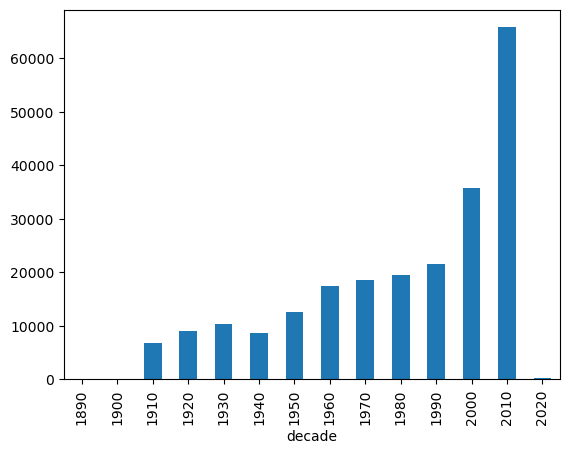

In [235]:
titles['decade'] = 10*(titles['year']//10)
tg=titles[titles['year']<2022].groupby('decade').count()
tg['title'].plot(kind='bar')

[Your answer to the ancillary question goes here]

### Use groupby() to plot the number of "Hamlet" films made each decade.

Solution without adding another column.  Use a groupby function.

In [236]:
#hamlet_by_decades = titles[titles['title']=='Hamlet'].groupby(lambda i: 10*(titles.loc[i].year//10))
hamlet_by_decades = titles[titles['title']=='Hamlet'].groupby(10*(titles.year//10)).count()

In [172]:
titles['decade'] = 10*(titles.year//10)
hamlet_by_decades2 = titles[titles['title']=='Hamlet'].groupby('decade').count()

In [209]:
hamlet_by_decades

,title,year
year,,
1910,3,3
1920,1,1
1940,1,1
1950,1,1
1960,2,2
1970,2,2
1980,1,1
1990,2,2
2000,2,2


<AxesSubplot:xlabel='year'>

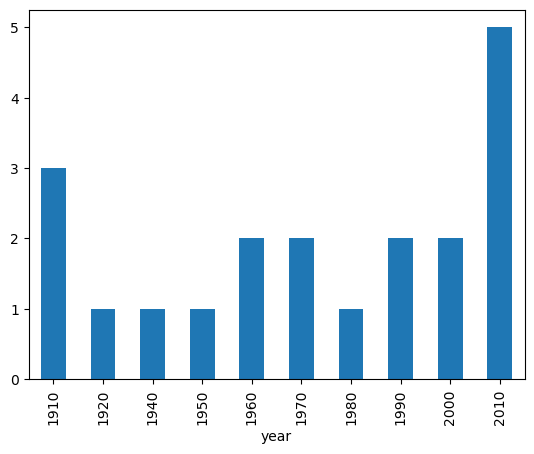

In [237]:
hamlet_by_decades['year'].plot(kind='bar')

### How many leading (n=1) roles were available to actors, and how many to actresses, in each year of the 1950s?

### In the 1950s decade taken as a whole, how many total roles were available to actors, and how many to actresses, for each "n" number 1 through 5?

First get a `DataFrame` restricted to the right rows.

In [90]:
c = cast
c['decade'] = 10*(cast['year']//10)
c = c[(c['decade'] == 1950)&(c['n']<=5)]

followed by one of two ways of grouping, which get equivalent results.

In [104]:
cg = c.groupby(['n'])
vc = cg['type'].value_counts()
vc

n    type   
1.0  actor      216
     actress     78
2.0  actor      145
     actress    137
3.0  actor      174
     actress     95
4.0  actor      165
     actress     67
5.0  actor      148
     actress     65
Name: type, dtype: int64

In [106]:
cg = c.groupby(['n','type'])
sz = cg.size()
sz

n    type   
1.0  actor      216
     actress     78
2.0  actor      145
     actress    137
3.0  actor      174
     actress     95
4.0  actor      165
     actress     67
5.0  actor      148
     actress     65
dtype: int64

### List each of the movies (year/title pairs) in which Peter Sellers has played at least two roles

In [74]:
#### List each of the movies (year/title pairs) in which Peter Sellers has played at least two roles

c = cast
c = c[c.name == 'Peter Sellers']
# A series whose values contain the answer
g = c.groupby(['year', 'title']).size()
# constrain to the right rows
g[g > 1]

year  title                                                               
1951  Penny Points to Paradise                                                2
1959  I'm All Right Jack                                                      2
      The Mouse That Roared                                                   3
1964  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb    3
1974  Soft Beds, Hard Battles                                                 6
1979  The Prisoner of Zenda                                                   3
1980  The Fiendish Plot of Dr. Fu Manchu                                      2
dtype: int64

### List the actor who has played the most roles in a single film together with the year and title of the film and the number of roles played. For extra credit (in a separate computation) list the roles that actor played in that film.

In [78]:
c=cast
# Each group is one actor's roles in a single film.
g_by = c.groupby(['name','year', 'title'])
ser = g_by.size()
ser.sort_values()[-1:]

name              year  title             
Dan Castellaneta  2007  The Simpsons Movie    21
dtype: int64

And here are the 21 roles.  Who can forget Castellaneta's performance as Multi-Eyed Squirrel?

In [77]:
g21 = g_by.get_group(('Dan Castellaneta',2007,'The Simpsons Movie'))
g21

,title,year,name,type,character,n
335731,The Simpsons Movie,2007,Dan Castellaneta,actor,Homer Simpson,1.0
335732,The Simpsons Movie,2007,Dan Castellaneta,actor,Itchy,1.0
335733,The Simpsons Movie,2007,Dan Castellaneta,actor,Barney,1.0
335734,The Simpsons Movie,2007,Dan Castellaneta,actor,Grampa,1.0
335735,The Simpsons Movie,2007,Dan Castellaneta,actor,Stage Manager,1.0
335736,The Simpsons Movie,2007,Dan Castellaneta,actor,Krusty the Clown,1.0
335737,The Simpsons Movie,2007,Dan Castellaneta,actor,Mayor Quimby,1.0
335738,The Simpsons Movie,2007,Dan Castellaneta,actor,Mayor's Aide,1.0
335739,The Simpsons Movie,2007,Dan Castellaneta,actor,Multi-Eyed Squirrel,1.0
335740,The Simpsons Movie,2007,Dan Castellaneta,actor,Panicky Man,1.0


### List each of the characters that Frank Oz has portrayed at least twice.